In [ ]:
!pip install tensorflow keras numpy pandas opencv-python kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramsaiachanta","key":"52d6827ad42fe89e10cda795460f8495"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/brain-tumor-mri-dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0726.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0727.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0728.jpg  
  inflating: dataset/Training/g

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# Dataset paths
train_dir = '/content/dataset/Training'
test_dir = '/content/dataset/Testing'

# Parameters
IMG_SIZE = (224, 224)  # DenseNet default input size
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4  # glioma, meningioma, pituitary, no_tumor

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # using 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
base_model = DenseNet201(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    include_top=False,   # Do not include the ImageNet classifier at the top
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
checkpoint = ModelCheckpoint(
    'best_densenet_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.5882 - loss: 0.9814
Epoch 1: val_accuracy improved from -inf to 0.72143, saving model to best_densenet_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 165s 838ms/step - accuracy: 0.5891 - loss: 0.9795 - val_accuracy: 0.7214 - val_loss: 0.7129
Epoch 2/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.6875 - loss: 0.6565

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.72143
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.6875 - loss: 0.6565 - val_accuracy: 0.7071 - val_loss: 0.7207
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8436 - loss: 0.4215
Epoch 3: val_accuracy improved from 0.72143 to 0.78839, saving model to best_densenet_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 118s 527ms/step - accuracy: 0.8437 - loss: 0.4215 - val_accuracy: 0.7884 - val_loss: 0.5846
Epoch 4/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8438 - loss: 0.3874
Epoch 4: val_accuracy did not improve from 0.78839
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.8438 - loss: 0.3874 - val_accuracy: 0.7839 - val_loss: 0.5802
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8734 - loss: 0.3636
Epoch 5: val_accuracy improved from 0.78839 to 0.79107, saving model to best_densenet_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 144s 646ms/step - accuracy: 0.8734 - loss: 0.3636 - val_accuracy: 0.7911 - val_loss: 0.5330
Epoch 6/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.8125 - loss: 0.4274
Epoch 6: val_accuracy improved from 0.79107 to 0.80804, saving model to best_densenet_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.8125 - loss: 0.4274 - val_accuracy: 0.8080 - val_loss: 0.5138
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8816 - loss: 0.3261
Epoch 7: val_accuracy did not improve from 0.80804
142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 517ms/step - accuracy: 0.8817 - loss: 0.3261 - val_accuracy: 0.8062 - val_loss: 0.5173
Epoch 8/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.8438 - loss: 0.4645
Epoch 8: val_accuracy did not improve from 0.80804
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.8438 - loss: 0.4645 - val_accuracy: 0.8054 - val_loss: 0.5264
Epoch 9/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8873 - loss: 0.3010
Epoch 9: val_accuracy improved from 0.80804 to 0.81875, saving model to best_densenet_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 144s 637ms/step - accuracy: 0.8873 - loss: 0.3010 - val_accuracy: 0.8188 - val_loss: 0.4861
Epoch 10/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.9688 - loss: 0.1330
Epoch 10: val_accuracy did not improve from 0.81875
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.9688 - loss: 0.1330 - val_accuracy: 0.8125 - val_loss: 0.4962
Epoch 11/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9073 - loss: 0.2652
Epoch 11: val_accuracy did not improve from 0.81875
142/142 ━━━━━━━━━━━━━━━━━━━━ 111s 527ms/step - accuracy: 0.9073 - loss: 0.2652 - val_accuracy: 0.8143 - val_loss: 0.4839
Epoch 12/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.9062 - loss: 0.1903
Epoch 12: val_accuracy did not improve from 0.81875
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.9062 - loss: 0.1903 - val_accuracy: 0.8125 - val_loss: 0.4772
Epoch 13/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9019 - loss: 0.2673
Epoc

142/142 ━━━━━━━━━━━━━━━━━━━━ 75s 524ms/step - accuracy: 0.9019 - loss: 0.2673 - val_accuracy: 0.8277 - val_loss: 0.4491
Epoch 14/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.9062 - loss: 0.1531
Epoch 14: val_accuracy improved from 0.82768 to 0.82857, saving model to best_densenet_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.9062 - loss: 0.1531 - val_accuracy: 0.8286 - val_loss: 0.4602
Epoch 15/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9111 - loss: 0.2511
Epoch 15: val_accuracy improved from 0.82857 to 0.83125, saving model to best_densenet_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 126s 523ms/step - accuracy: 0.9111 - loss: 0.2511 - val_accuracy: 0.8313 - val_loss: 0.4775
Epoch 16/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.9375 - loss: 0.1598
Epoch 16: val_accuracy did not improve from 0.83125
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9375 - loss: 0.1598 - val_accuracy: 0.8286 - val_loss: 0.4837
Epoch 17/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9150 - loss: 0.2397
Epoch 17: val_accuracy improved from 0.83125 to 0.83839, saving model to best_densenet_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 76s 535ms/step - accuracy: 0.9150 - loss: 0.2397 - val_accuracy: 0.8384 - val_loss: 0.4543
Epoch 18/20
  1/142 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.8750 - loss: 0.3956
Epoch 18: val_accuracy did not improve from 0.83839
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.8750 - loss: 0.3956 - val_accuracy: 0.8223 - val_loss: 0.4608
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.


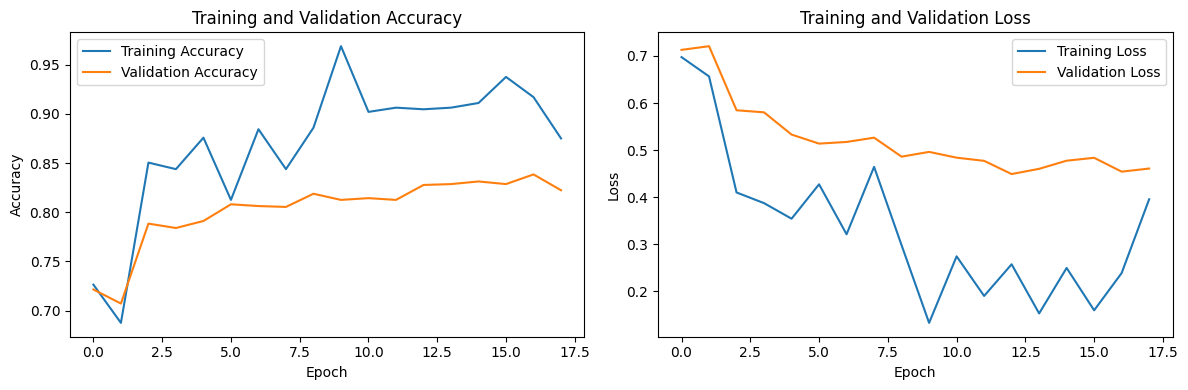

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 631ms/step - accuracy: 0.7380 - loss: 0.6979
Test Accuracy: 0.8352
Test Loss: 0.4556


41/41 ━━━━━━━━━━━━━━━━━━━━ 45s 581ms/step


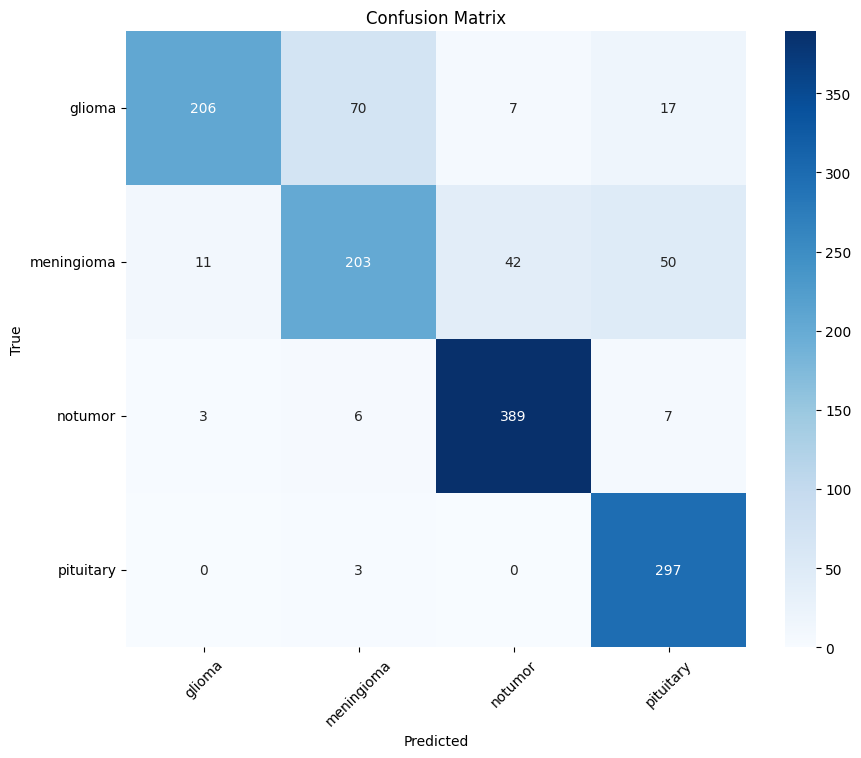


Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.69      0.79       300
  meningioma       0.72      0.66      0.69       306
     notumor       0.89      0.96      0.92       405
   pituitary       0.80      0.99      0.89       300

    accuracy                           0.84      1311
   macro avg       0.84      0.83      0.82      1311
weighted avg       0.84      0.84      0.83      1311



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Optional: Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

In [ ]:
model.save('brain_tumor_densenet_part2.h5')